# Binder classification with combined SMILES fingerprints and RDKit descriptors

This notebook merges the previously separate SMILES-fingerprint and RDKit-descriptor workflows. It loads the curated IC50 dataset, cleans it, generates Morgan fingerprints plus RDKit descriptors for each molecule, aligns compounds that have both representations, and evaluates classification models on the concatenated feature space.

In [1]:
import os
os.environ.setdefault('OMP_NUM_THREADS', '1')
os.environ.setdefault('RDKIT_MAX_THREADS', '1')
os.environ.setdefault('RDKIT_DISABLE_THREADS', '1')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from rdkit.ML.Descriptors import MoleculeDescriptors

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    precision_recall_curve,
    roc_curve,
    roc_auc_score,
    auc,
    matthews_corrcoef,
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
)
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
from IPython.display import display

plt.rcParams.update({"figure.figsize": (8, 5), "axes.grid": True})

In [2]:
# Load and clean the IC50 dataset

df = pd.read_csv("ic50.tsv", sep="	", low_memory=False)
df["Standard Value"] = pd.to_numeric(df["Standard Value"], errors="coerce")

df = df.dropna(subset=["Standard Value", "Smiles"]).copy()
df["Binder"] = (df["Standard Value"] <= 2000).astype(int)

unwanted_patterns = [
    ".C", ".Cl", ".NA+", ".Na+", ".na+", "[Na+]", "Cl.", ".O=C(O)C(F)(F)F"
]
mask = pd.Series(False, index=df.index)
for pattern in unwanted_patterns:
    mask |= df["Smiles"].str.contains(pattern, regex=False, na=False)
removed = int(mask.sum())
if removed:
    df = df[~mask].copy()
    print(f"Removed {removed} compounds due to unwanted ion patterns")

dupe_mask = df.duplicated(subset="Smiles", keep="first")
removed_dupes = int(dupe_mask.sum())
if removed_dupes:
    df = df[~dupe_mask].copy()
    print(f"Removed {removed_dupes} duplicate SMILES entries")

df = df.reset_index(drop=True)
print(f"Dataset size after cleaning: {len(df)} compounds")
print(f"Binder ratio (<=2000 nM): {df['Binder'].mean()*100:.2f}%")
print("Sample molecules:")
for i, (_, row) in enumerate(df.head(5).iterrows(), 1):
    smiles_str = row['Smiles'][:70] + "..." if len(row['Smiles']) > 70 else row['Smiles']
    print(f"  {i}. {smiles_str} | Binder: {row['Binder']}")

Removed 25 compounds due to unwanted ion patterns
Removed 787 duplicate SMILES entries
Dataset size after cleaning: 2039 compounds
Binder ratio (<=2000 nM): 64.64%
Sample molecules:
  1. CN(C)OC(=O)CCC(=O)O | Binder: 0
  2. CC(=O)CC(=O)CCC(=O)O | Binder: 0
  3. Cc1cccc(C)c1Oc1cc2c(N3CCCC3)nc(-n3cc(C(=O)O)cn3)nc2cc1F | Binder: 1
  4. N#Cc1cccc(NC(=O)c2ccc3cccnc3c2O)c1 | Binder: 0
  5. COc1ccc(CNC(=O)c2ccc3cccnc3c2O)cc1 | Binder: 0


In [3]:
# Morgan fingerprint generation

morgan_generator = GetMorganGenerator(radius=2, fpSize=4096)

def smiles_to_morgan_bits(smiles: str):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    try:
        fp = morgan_generator.GetFingerprint(mol)
        return np.array(fp, dtype=np.int8)
    except Exception:
        return None

fingerprint_rows = []
fingerprint_indices = []
print("Converting SMILES to 4096-bit Morgan fingerprints...")
for idx, smiles in df['Smiles'].items():
    fp = smiles_to_morgan_bits(smiles)
    if fp is not None:
        fingerprint_rows.append(fp)
        fingerprint_indices.append(idx)

X_fp = np.asarray(fingerprint_rows)
y_fp = df.loc[fingerprint_indices, 'Binder'].to_numpy()
print(f"Valid fingerprint count: {X_fp.shape[0]} (out of {len(df)})")
print(f"Fingerprint matrix shape: {X_fp.shape}")

Converting SMILES to 4096-bit Morgan fingerprints...
Valid fingerprint count: 2039 (out of 2039)
Fingerprint matrix shape: (2039, 4096)


In [4]:
# RDKit descriptor calculation

descriptor_names = [name for name, _ in Descriptors._descList]
descriptor_calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)

def smiles_to_descriptors(smiles: str):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    try:
        return descriptor_calculator.CalcDescriptors(mol)
    except Exception:
        return None

print("Calculating RDKit descriptors...")
descriptor_rows = []
descriptor_indices = []
for idx, smiles in df['Smiles'].items():
    values = smiles_to_descriptors(smiles)
    if values is not None:
        descriptor_rows.append(values)
        descriptor_indices.append(idx)

descriptor_df = (pd.DataFrame(descriptor_rows, columns=descriptor_names, index=descriptor_indices)
                 .replace([np.inf, -np.inf], np.nan))
descriptor_df = descriptor_df.dropna(axis=1, how='all')
descriptor_df = descriptor_df.fillna(descriptor_df.median())
float32_limit = np.finfo(np.float32).max
large_mask = descriptor_df.abs() >= float32_limit
if large_mask.any().any():
    bad_cols = descriptor_df.columns[large_mask.any(axis=0)].tolist()
    descriptor_df = descriptor_df.drop(columns=bad_cols)
    print(f"Dropped {len(bad_cols)} descriptor(s) exceeding float32 limits: {bad_cols}")

descriptor_df = descriptor_df.astype(np.float64)
print(f"Descriptor matrix shape: {descriptor_df.shape}")
print(f"Valid descriptor count: {descriptor_df.shape[0]}")

Calculating RDKit descriptors...
Dropped 1 descriptor(s) exceeding float32 limits: ['Ipc']
Descriptor matrix shape: (2039, 216)
Valid descriptor count: 2039


In [5]:
# Align molecules with both fingerprints and descriptors, then combine features

fp_idx_map = {idx: pos for pos, idx in enumerate(fingerprint_indices)}
desc_idx_map = {idx: pos for pos, idx in enumerate(descriptor_df.index.tolist())}
shared_indices = sorted(set(fp_idx_map) & set(desc_idx_map))
print(f"Molecules with both feature sets: {len(shared_indices)}")

X_fp_shared = X_fp[[fp_idx_map[idx] for idx in shared_indices]]
X_desc_shared = descriptor_df.loc[shared_indices].to_numpy()
y_shared = df.loc[shared_indices, 'Binder'].to_numpy()

X_combined = np.hstack([X_fp_shared, X_desc_shared])
desc_start = X_fp_shared.shape[1]
print(f"Combined feature matrix shape: {X_combined.shape}")
print(f"Fingerprint block: {X_fp_shared.shape[1]} columns, descriptor block: {X_desc_shared.shape[1]} columns")

Molecules with both feature sets: 2039
Combined feature matrix shape: (2039, 4312)
Fingerprint block: 4096 columns, descriptor block: 216 columns


Random Forest performance on holdout split (combined features)
PR-AUC: 0.9881
ROC-AUC: 0.9768
MCC: 0.8486
Accuracy: 0.9314
Balanced Accuracy: 0.9179
              precision    recall  f1-score   support

  Non-binder       0.93      0.87      0.90       180
      Binder       0.93      0.96      0.95       330

    accuracy                           0.93       510
   macro avg       0.93      0.92      0.92       510
weighted avg       0.93      0.93      0.93       510



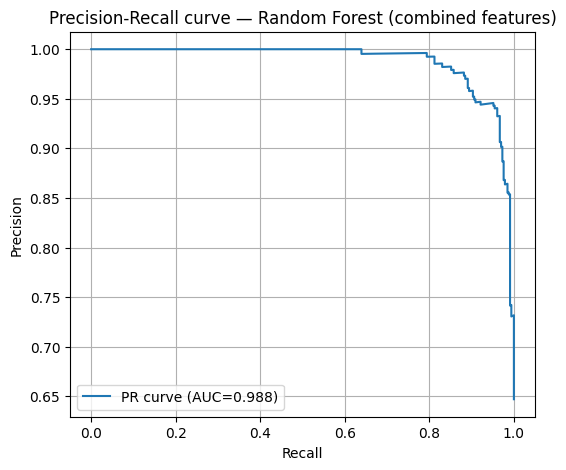

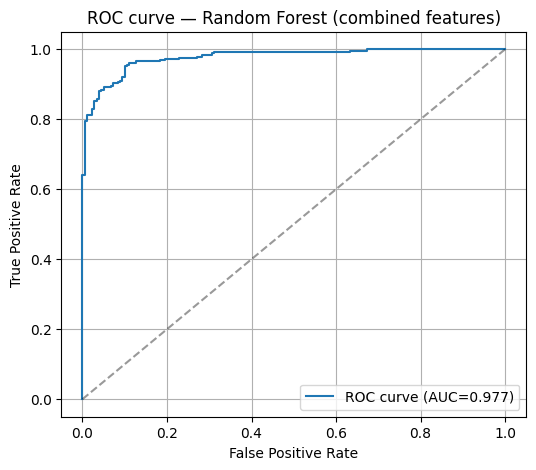

In [6]:
# Train/test split and baseline Random Forest evaluation

X_train, X_test, y_train, y_test = train_test_split(
    X_combined,
    y_shared,
    test_size=0.25,
    random_state=42,
    stratify=y_shared,
)

rf_combined = RandomForestClassifier(
    n_estimators=500,
    random_state=42,
    n_jobs=-1,
    max_depth=24,
    min_samples_leaf=2,
)
rf_combined.fit(X_train, y_train)

y_pred = rf_combined.predict(X_test)
y_prob = rf_combined.predict_proba(X_test)[:, 1]

precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall_curve, precision_curve)
roc_auc = roc_auc_score(y_test, y_prob)
mcc = matthews_corrcoef(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)

print("Random Forest performance on holdout split (combined features)")
print(f"PR-AUC: {pr_auc:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"MCC: {mcc:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"Balanced Accuracy: {bal_acc:.4f}")
print(classification_report(y_test, y_pred, target_names=["Non-binder", "Binder"]))

plt.figure(figsize=(6, 5))
plt.plot(recall_curve, precision_curve, label=f"PR curve (AUC={pr_auc:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve — Random Forest (combined features)")
plt.legend()
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC={roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--', alpha=0.4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve — Random Forest (combined features)")
plt.legend()
plt.show()

In [10]:
# Cross-validated comparison across multiple classifier families

def _positive_class_probs(model, X):
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    if hasattr(model, "decision_function"):
        raw = model.decision_function(X)
        return 1.0 / (1.0 + np.exp(-raw))
    return model.predict(X).astype(float)

def _metric_summary(y_true, y_pred, y_prob):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    return {
        "PR_AUC": auc(recall, precision),
        "ROC_AUC": roc_auc_score(y_true, y_prob),
        "MCC": matthews_corrcoef(y_true, y_pred),
        "Accuracy": accuracy_score(y_true, y_pred),
    }

def run_stratified_kfold(model, X, y, n_splits=5, random_state=42):
    splitter = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    fold_metrics = []
    for train_idx, test_idx in splitter.split(X, y):
        estimator = clone(model)
        estimator.fit(X[train_idx], y[train_idx])
        y_pred = estimator.predict(X[test_idx])
        y_prob = _positive_class_probs(estimator, X[test_idx])
        fold_metrics.append(_metric_summary(y[test_idx], y_pred, y_prob))
    return {metric: np.mean([fold[metric] for fold in fold_metrics]) for metric in fold_metrics[0]}

model_registry = {
    "RandomForest": RandomForestClassifier(
        n_estimators=500,
        random_state=42,
        n_jobs=-1,
        max_depth=24,
        min_samples_leaf=2,
    ),
    "ExtraTrees": ExtraTreesClassifier(
        n_estimators=600,
        random_state=42,
        n_jobs=-1,
        max_depth=None,
        min_samples_leaf=1,
    ),
    "GradientBoosting": GradientBoostingClassifier(
        random_state=42,
        learning_rate=0.05,
        n_estimators=400,
        max_depth=3,
    ),
    "LogisticRegression": make_pipeline(
        StandardScaler(with_mean=False),
        LogisticRegression(
            penalty='elasticnet',
            l1_ratio=0.3,
            solver='saga',
            max_iter=4000,
            random_state=42,
            class_weight='balanced',
            n_jobs=-1,
        )
    ),
    "GaussianNB": make_pipeline(
        StandardScaler(with_mean=False),
        GaussianNB(var_smoothing=1e-9)
    )
}

fold_options = [10]
cv_rows = []
for model_name, estimator in model_registry.items():
    for folds in fold_options:
        metrics = run_stratified_kfold(estimator, X_combined, y_shared, n_splits=folds)
        metrics.update({"Model": model_name, "Folds": folds})
        cv_rows.append(metrics)

cv_df = (pd.DataFrame(cv_rows)
         .sort_values(by=["Model", "Folds"])         .reset_index(drop=True))
print("Cross-validated combined-feature model comparison:")
try:
    display(cv_df)
except Exception as exc:
    print("Display unavailable:", exc)
    print(cv_df)

/Users/salmashahzad/Desktop/research me /.venv/lib/python3.14/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/salmashahzad/Desktop/research me /.venv/lib/python3.14/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/salmashahzad/Desktop/research me /.venv/lib/python3.14/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/salmashahzad/Desktop/research me /.venv/lib/python3.14/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/salmashahzad/Desktop/research me /.venv/lib/python3.14/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached w

Cross-validated combined-feature model comparison:


,PR_AUC,ROC_AUC,MCC,Accuracy,Model,Folds
0,0.985651,0.975173,0.844110,0.928395,ExtraTrees,10
1,0.904679,0.800012,0.572769,0.790085,GaussianNB,10
2,0.987060,0.977097,0.846501,0.929875,GradientBoosting,10
3,0.971639,0.961546,0.824325,0.919572,LogisticRegression,10
4,0.986957,0.977089,0.836793,0.925452,RandomForest,10
